# Pointwise Mutual Information (PMI)

Definition:

`PMI(w1, w2) = log(P(w1, w2)/P(w1)*P(w2)) = log(P(w2|w1)/P(w2)) = log(P(w1|w2)/P(w1))`

Properties:

 - `PMI(w1, w2) = 0`  iff w1 and w2 are independent (since `PMI(w1, w2) = 0` iff `P(w1, w2) = P(w1)*P(w2)`)
 - `PMI(w1, w2) < 0`iff w1 and w2 occur more frequently in separation than together
 - Symmetric (`PMI(w1, w2) = PMI(w2, w1)` since `P(w1, w2) = P(w1w2) + P(w2w1)` (and by the symmetry of information)

In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from utils import CountVectorizer, TfidfVectorizer, Ngram

In [2]:
obj_tbl = pd.read_csv("../../data/tables/Objects.csv.gz")
str_cols = "Title", "Description"
txts = [s for col in str_cols for s in obj_tbl[col].dropna()]

print("number of docs: ", len(txts))
# print("number of docs: ", len(txts))

number of docs:  11199


In [3]:
tokens = [w for txt in txts for w in txt.split()]

print("number of tokens: ", len(tokens))
print("number of types: ", len(set(tokens)))
print("TTR: ", len(set(tokens))/len(tokens))

number of tokens:  274580
number of types:  43518
TTR:  0.15848932915725836


## N-grams

In [4]:
NG = Ngram((1,2), txts, precompute_freqs=True)

(1, 2)-grams: Term Document Matrix constructed...
(1, 2)-grams: Term frequencies precomputed...
(1, 2)-grams: Init done


In [ ]:
# save for later
NG.save("count")

## PMI

compute PMI values for all observed pairs of words

In [5]:
pmis = {w: NG.pmi(*w.split()) for w in NG.vocab(2)}

In [16]:
from tabulate import tabulate

tab = []
for w, val in sorted(pmis.items(), key=lambda tup: tup[1], reverse=True):
    if 9.5 < val < 110:
        u, v = w.split()
        if NG.freq(u)+NG.freq(v) > 10:
            tab.append((*w.split(), round(val, 4), NG.freq(u), NG.freq(v), NG.freq(u, v)))
            
            
print(tabulate(tab[70:100], headers=["w1", "w2","PMI", "f(w1)", "f(w2)", "f(w1w2)"]))

w1                    w2                   PMI    f(w1)    f(w2)    f(w1w2)
--------------------  ---------------  -------  -------  -------  ---------
nuoc                  con              16.2251        6        7          6
naaldbomen            ceders           16.2251        6        7          6
dreiging              heerst           16.2251        7        6          6
rolle                 berlijn          16.2251        5        7          5
gardens               xochimilco       16.2251        7        7          7
ibn                   salam            16.2251        6        7          6
ernesto               castillo         16.2251        7        6          6
ditzelfde             collectienummer  16.2251        7        6          6
medemens              decennia         16.2251        4        7          4
chiang                mai              16.2251        5        7          5
ingekerfde            vierhoek         16.2251        7        4          4
jurfepin    

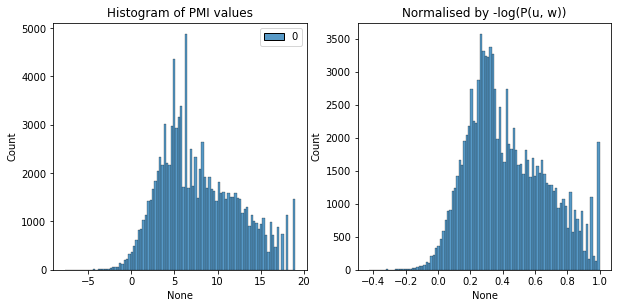

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.histplot(pmis.values())
plt.title("Histogram of PMI values")


joint = lambda u, v: NG.cond_prob(u, v)*NG.prob(u)
norm = lambda u, v: -np.log2(joint(u, v))

plt.subplot(2, 2, 2)
# sns.histplot([pmi_val/(NG.freq(w.split()[0]) + NG.freq(w.split()[1])) for w, pmi_val in pmis.items()])

sns.histplot([pmi_val/norm(*w.split()) for w, pmi_val in pmis.items()])
_ = plt.title("Normalised by -log(P(u, w))")

In [32]:
print("pairs with PMI < 17 and combined frequency <= 2:")
for w, x in pmis.items():
    if x < 17:
        u, v = w.split() 
        if NG.freq(u) == NG.freq(v) == 1:
            print("\t", u, v)

pairs with PMI < 15 and combined frequency <= 2:


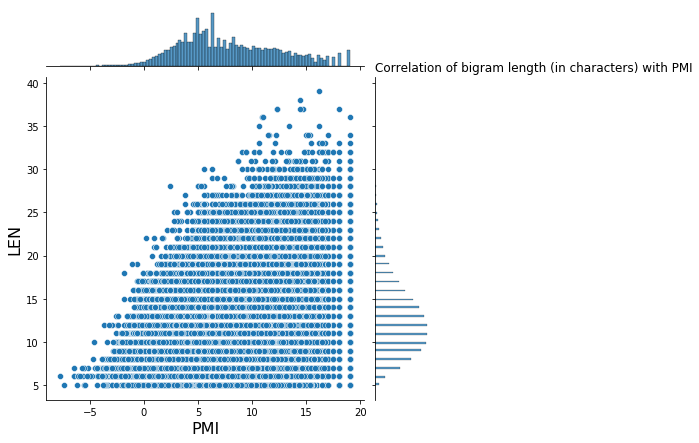

In [37]:
lens, pmi_vals = list(zip(*map(lambda t: (len(t[0]), t[1]), pmis.items())))

h = sns.jointplot(x=pmi_vals, y=lens)
h.set_axis_labels('PMI', 'LEN', fontsize=16)
_ = plt.title("Correlation of bigram length (in characters) with PMI", loc="left")

100%|██████████| 108831/108831 [00:00<00:00, 218213.37it/s]


108831 108831 108831


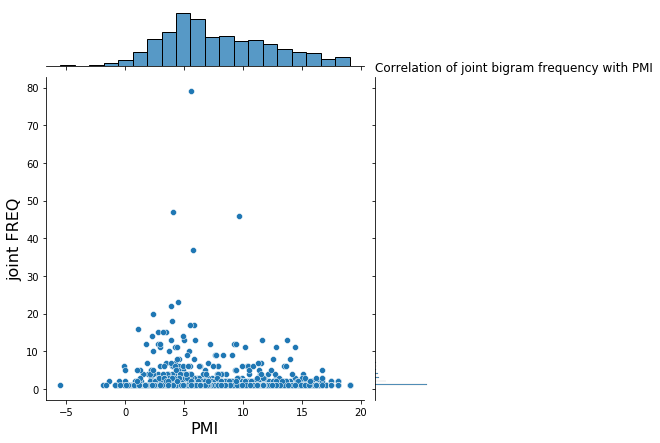

In [42]:
fs, pmi_vals = list(zip(*map(lambda t: (NG.freq(*(t[0].split())), t[1]), tqdm(pmis.items()))))

print(len(fs), len(pmi_vals), len(lens))

h = sns.jointplot(x=pmi_vals[:1000], y=fs[:1000])
_ = h.set_axis_labels('PMI', 'joint FREQ', fontsize=16)
_ = plt.title("Correlation of joint bigram frequency with PMI", loc="left")

100%|██████████| 108831/108831 [00:00<00:00, 339158.95it/s]


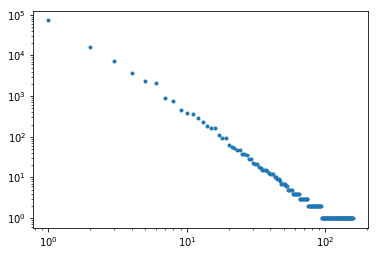

In [55]:
joint_freqs = [NG.freq(*w.split()) for w in tqdm(NG.vocab(2))]

# _ = sns.histplot(np.random.permutation(joint_freqs)[:1000])

from collections import Counter

freq_counts = Counter(joint_freqs)
rs, fs = list(zip(*enumerate((f for _, f in freq_counts.most_common()), start=1
                            )))


_ = plt.loglog(rs, fs, ".")

# Tracking a Term

### 1. words associated with a given word


*observations*

 - need to apply proper linguistic analyses to capture all variants of a word stem  
   -> merging could also be a parameter 
 - bias via lexical association should be assymmetric  (*all X are Y* implies bias about X, but not bias about Y)
 - lexical association bias is definitely also about **lack** of association (where are the "Chinese colonials"? "German colonials" exist)  
   measure lack of association by doing set difference across equivalence classes established by unigrams
 - what to do about low frequencies of pairs?

In [57]:
w = "chinees"

for w2 in NG.vocab(1):
    if w2.startswith(w) or w2.endswith(w):
        print(w2)
        
w_pairs = {pair: (v, NG.freq(*pair.split())) 
           for pair, v in pmis.items() if pair.startswith(w) or pair.endswith(w)}

sorted(w_pairs.items(), key=lambda t: t[1], reverse=True)[:-1]

chineese
chinees
chineesche
chineesch


[('chineesche voorstraat', (16.71054279066365, 1)),
 ('chineesch theater', (16.71054279066365, 1)),
 ('chineesche prostituees', (16.71054279066365, 1)),
 ('chineese wijk', (15.12558028994249, 1)),
 ('chinees porcelein', (12.882723766046329, 2)),
 ('chinees imari', (12.882723766046329, 2)),
 ('regelig chinees', (12.882723766046329, 1)),
 ('chinees verdiepingen', (12.882723766046329, 1)),
 ('chinees nieuwjaar', (12.467686266767483, 6)),
 ('chineesche wajang', (12.010103072522558, 1)),
 ('chinees shih', (11.882723766046329, 1)),
 ('chineesche tempel', (11.462615277220063, 2)),
 ('djakarta chinees', (11.297761265325173, 1)),
 ('kapitein chinees', (11.297761265325173, 1)),
 ('maleis chinees', (11.297761265325173, 1)),
 ('chinees oei', (11.297761265325171, 1)),
 ('chinees laboean', (10.882723766046329, 1)),
 ('ty chinees', (10.882723766046329, 1)),
 ('luitenant chinees', (10.075368843988725, 1)),
 ('chinees borduursel', (9.882723766046329, 1)),
 ('chinees gedicht', (9.882723766046329, 1)),
 

### 2. documents in which a pair occurs (and other pairs in that)

In [58]:
pair = "chinees nieuwjaar"

i = NG.vocab()[pair]


found = np.argwhere(NG.term_doc_matrix[:, i] > 0)[:, 0]
pair_txts = [txts[ind] for ind in found]
found, pair_txts

(array([ 8777,  8778, 10568, 10569, 10570, 10571], dtype=int32),
 ["Een van de zes (zeven) wintergezichten in Tartarije\r\n\r\nGezicht op figuren in een winters landschap met een tentenkamp buiten een ommuurde woonstede.\r\n\r\nOp deze schildering is een klein tentenkamp van het vendel Rood omrand te zien buiten de muur van de woonstede van een Mandarijn.  In de verte zijn meer tenten zichtbaar. De woning van een Mandarijn is doorgaans herkenbaar aan twee hoge palen die terzijde van de poort staan. Overdag worden hieraan twee vlaggen bevestigd als teken van zijn waardigheid en 's nachts zijn ze voorzien van lampions.  Een wapperende vlag met Chinese tekens is op het schilderij afgebeeld. Hooggeplaatste Chinezen zonderden zich graag af, daarom waren hun woningen vaak omgeven door een muur. De plek zou ook het keizerlijke onderkomen in Jehol (het huidige Chengde) kunnen voorstellen, aangezien er goudgele daken op de gebouwen binnen de muur te zien zijn. Deze kleur dakbedekking mocht alle

In [59]:
all_pairs = pair_txts[0].split()
all_pairs = [(w1 + " " + w2).lower() for w1, w2 in zip(all_pairs[:-1], all_pairs[1:])]

sorted(((p, pmis[p], NG.freq(p)) for p in all_pairs if p in pmis), key=lambda t: t[1], reverse=True)

[('ommuurde woonveste', 17.447508384829852, 1),
 ('chao dai', 17.447508384829852, 3),
 ('afgezaagde boomstronken', 16.71054279066365, 1),
 ('guiseppe castiglione', 16.447508384829852, 6),
 ('minds perceive', 16.447508384829852, 6),
 ('observes bleakness', 16.447508384829852, 6),
 ('keenly observed', 16.447508384829852, 6),
 ('thereupon expressed', 16.447508384829852, 6),
 ('lifeless trunks', 16.447508384829852, 6),
 ('goudgele daken', 16.225115963493405, 1),
 ('voorgebergten fungeerden', 16.03247088555101, 6),
 ('latter refers', 16.03247088555101, 6),
 ('favoriet seizoen', 15.862545884108698, 6),
 ('notie betekende', 15.862545884108698, 6),
 ('shanshui hua', 15.710542790663649, 6),
 ('human minds', 15.710542790663647, 6),
 ('terugkerend fenomeen', 15.640153462772249, 6),
 ('special exhibition', 15.617433386272166, 6),
 ('william shang', 15.447508384829854, 12),
 ('william shang', 15.447508384829854, 12),
 ('brachten gravures', 15.332031167409916, 6),
 ('important component', 15.3320311

In [63]:
all_pairs = pair_txts[0].split()
all_pairs = [(w + " " + w2).lower() for w2 in all_pairs] + [(w2 + " " + w).lower() for w2 in all_pairs]

sorted(((p, pmis[p], NG.freq(p)) for p in all_pairs if p in pmis), key=lambda t: t[1], reverse=True)

[]